images_experiment/220304_miliq_T17.7_S73.04.png


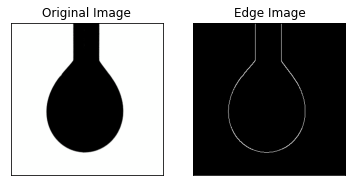

In [104]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
# use miliq as the input image.

input_path=os.path.relpath('./images_experiment/220304_miliq_T17.7_S73.04.png')
print(input_path)
img=cv2.imread(input_path)

assert img is not None, 'file could not be read, check with os.path.exists()'
edges=cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()


100%|██████████| 323/323 [00:00<00:00, 2882.08it/s]


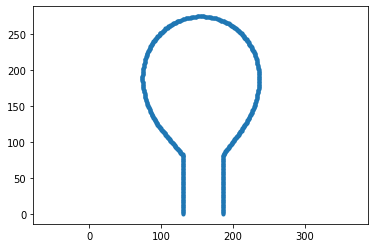

In [105]:
r=[]
z=[]

for i in tqdm(range (edges.shape[0])):
    for j in range(edges.shape[1]):
        if edges[i,j]!=0:
            r.append(j)
            z.append(i)

scale=abs(1/(r[0]-r[1])) # 1 means the diameter of needle is 1mm
r=np.array(r)
z=np.array(z)

plt.plot(r,z,'.')
plt.axis('equal')
plt.show()

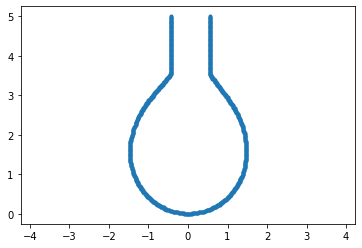

In [106]:
# Converting image coordinates to analytical coordinates,
# to let the apex's coordinate is (0,0)
# And the direction of gravity is downward along the coordinate axis-z

# Set apex's z-coordinates to 0
shift_z=max(z)

zshift=np.array(z)
zshift=zshift-shift_z
zshift=np.abs(zshift)

rshift=np.array(r)
rz=np.vstack([rshift,zshift])
rz=np.transpose(rz)

# Set apex's r-coordinates to 0
apex=np.where(rz[:,1]==0)

shift_r=[]
for i in apex:
    shift_r.append(rz[i,0])
shift_r=int(np.mean(shift_r))

rz[:,0]=rz[:,0]-shift_r

# Scale coordinates to actual size
rz=rz*scale 

#Visualisation
plt.plot(rz[:,0],rz[:,1],'.')
plt.axis('equal')
plt.show()

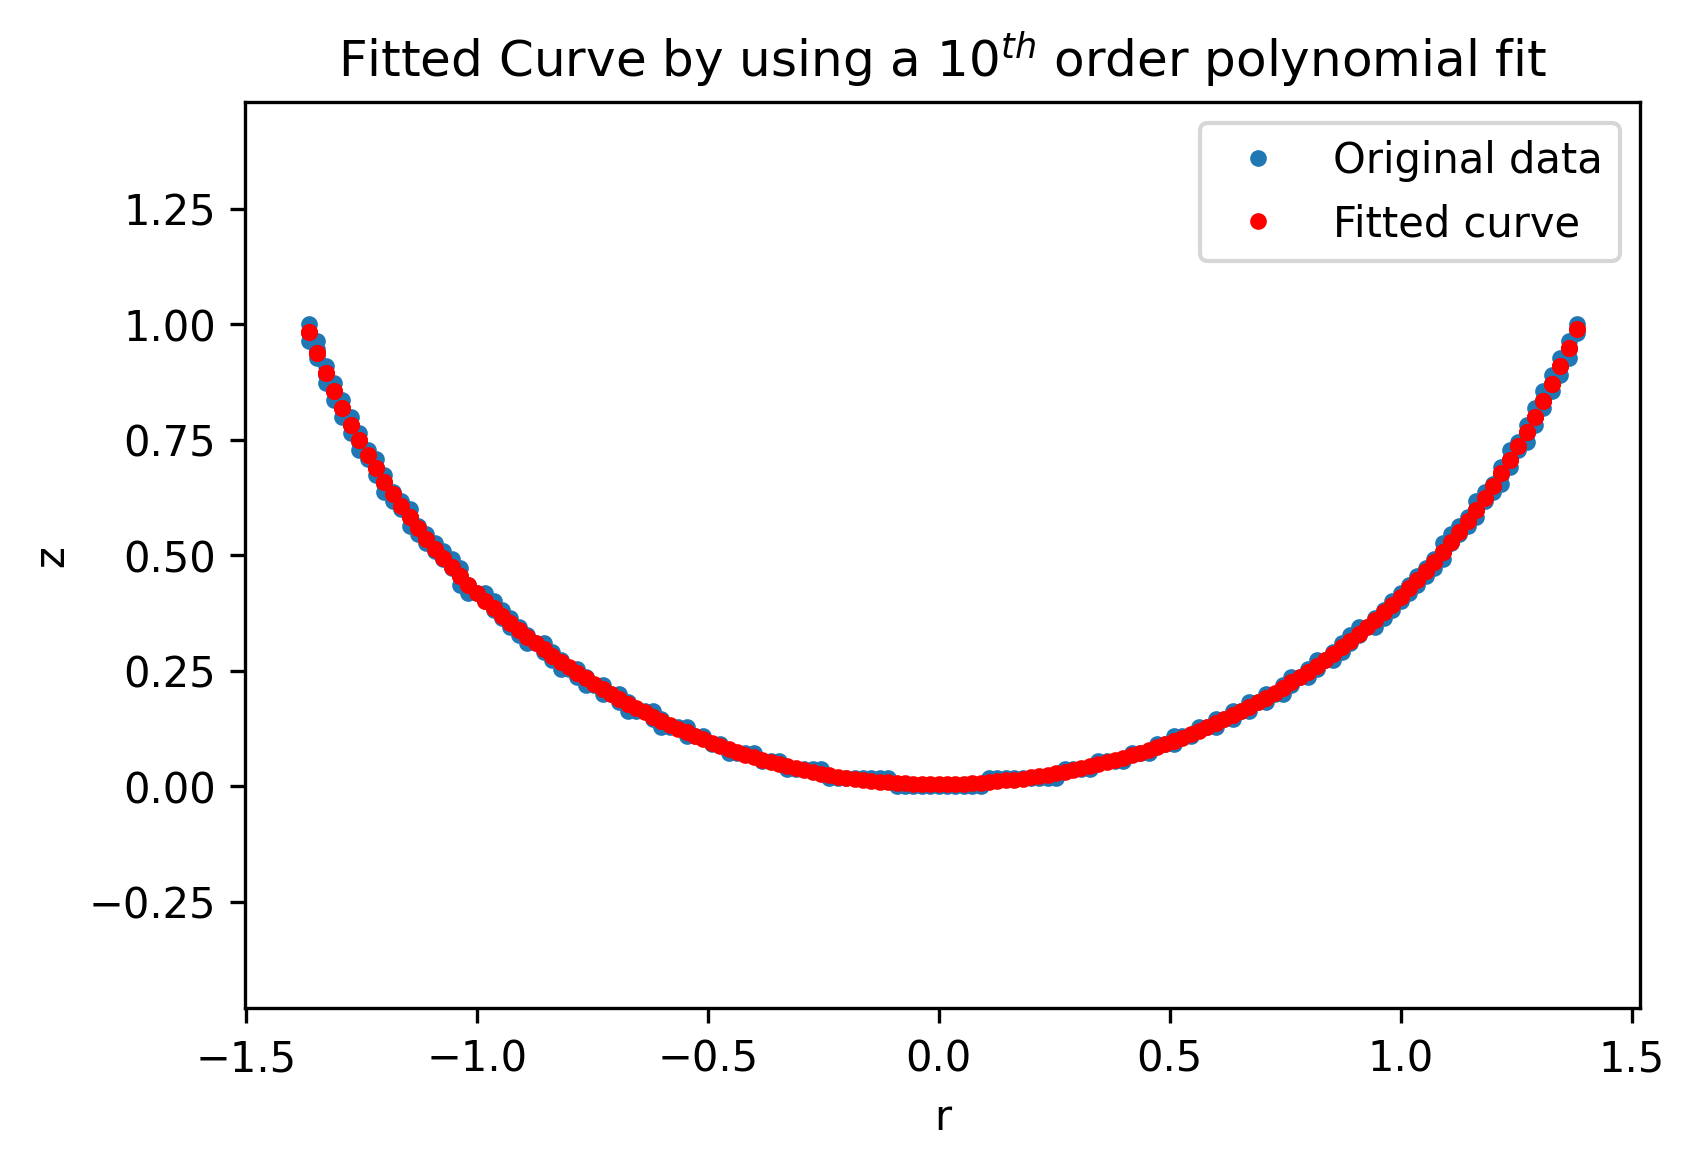

In [107]:
# Use pandas to remove the needle and cut the drop in half.
import pandas as pd
rz_df=pd.DataFrame(rz,columns=['r','z'],dtype=float)

# remove the needle
rz_df=rz_df.drop(rz_df[rz_df['z']>1].index)

# change dataframe to numpy
rz_np=rz_df.to_numpy()

# Use polyfit to fitting the curve.
coeffs=np.polyfit(rz_np[:,0],rz_np[:,1],deg=8)
fitz=np.polyval(coeffs,rz_np[:,0])

# visualising the result
plt.figure(dpi=300)
# original data
plt.plot(rz_np[:,0],rz_np[:,1],'.')
# fitted curve
plt.plot(rz_np[:,0],fitz,'.',color='r')
plt.legend(['Original data','Fitted curve'])
plt.title('Fitted Curve by using a $10^{th}$ order polynomial fit')
plt.axis('equal')
plt.xlabel('r')
plt.ylabel('z')
plt.show()

In [108]:
# calculate the curvature at apex
# The algorithm principle comes from https://zhuanlan.zhihu.com/p/72083902

def calculate_curvature(p1,p2,p3):
    x1,y1=p1
    x2,y2=p2
    x3,y3=p3
    
    ta=np.sqrt((x2-x1)**2+(y2-y1)**2)
    tb=np.sqrt((x3-x2)**2+(y3-y2)**2)

    M=[[1, -ta, ta**2],[1,0,0],[1,tb,tb**2]]
    X=[[x1],[x2],[x3]]
    Y=[[y1],[y2],[y3]]

    [[a1],[a2],[a3]]=np.matmul(np.linalg.inv(M),X)
    [[b1],[b2],[b3]]=np.matmul(np.linalg.inv(M),Y)

    k=2*(a3*b2-a2*b3)/((a2**2+b2**2)**(3/2))

    return k

In [109]:
delta_r=0.00001
r2=0
r1,r3=r2-delta_r,2+delta_r

z1,z2,z3=np.polyval(coeffs,[r1,r2,r3])

p1,p2,p3=[r1,z1],[r2,z2],[r3,z3]
#fitz=np.polyval(coeffs,rz_np[:,0])

R0=abs(1/calculate_curvature(p1,p2,p3))
print(R0)

3.2286369025378017


1.4604158844048876


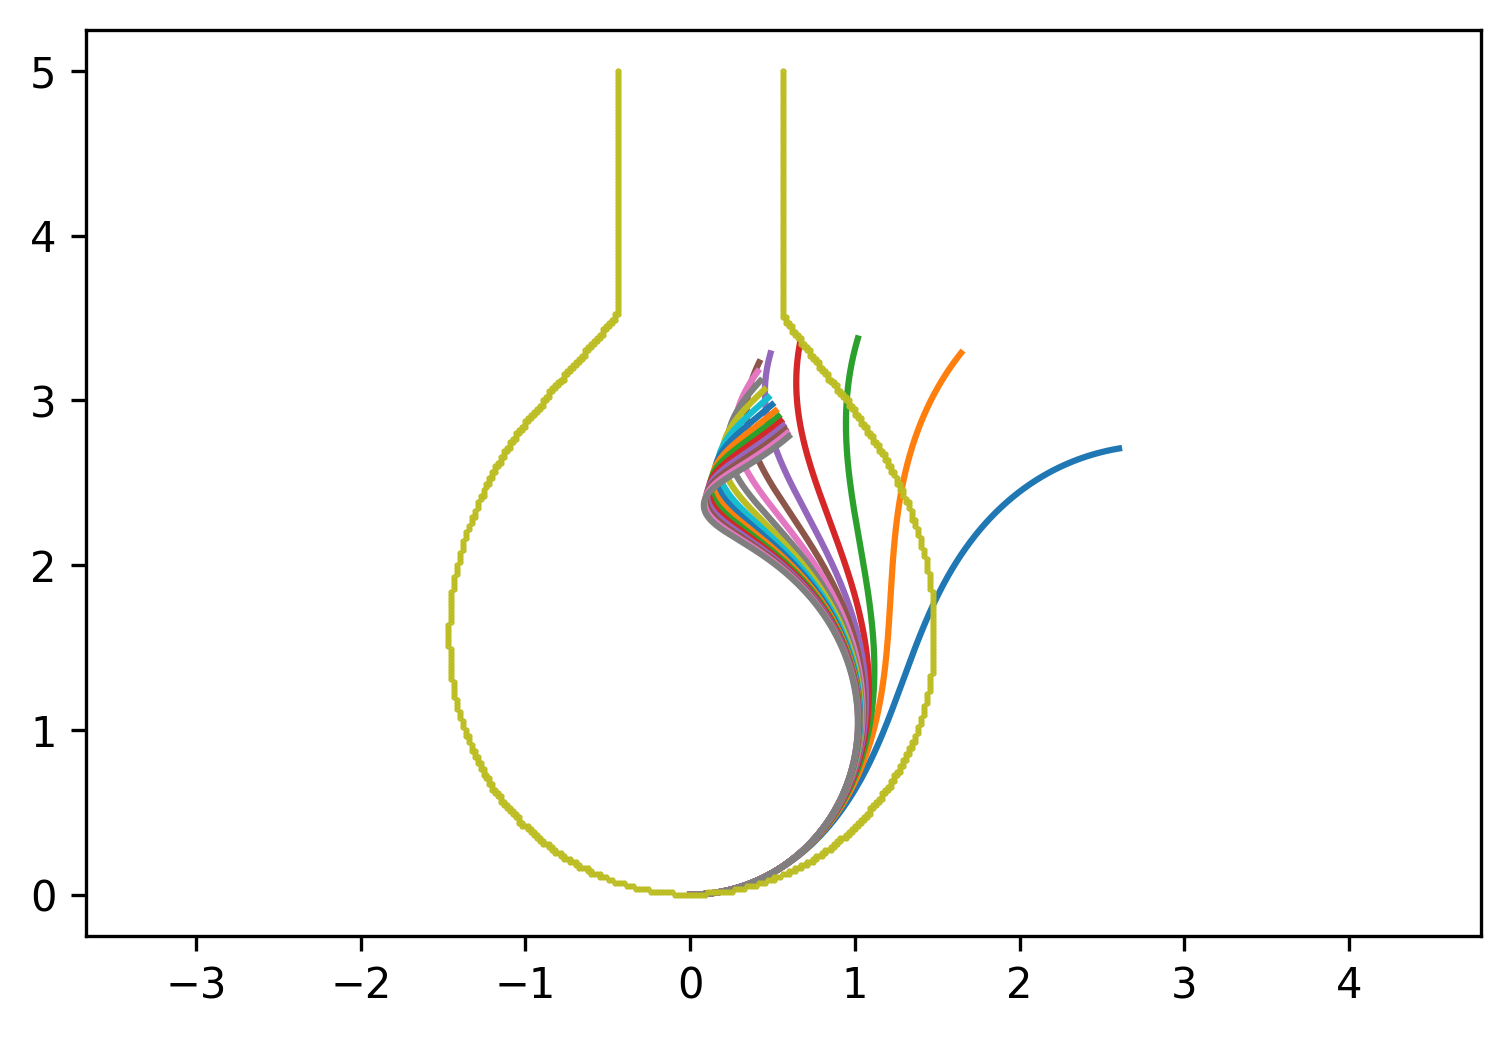

In [113]:
import math as m
from scipy.integrate import solve_ivp

grav = 9.807e3;         # gravitational acceleration [mm/s^2]
delta_rho = 1e-3;        # density difference [10^6 kg/m^3]
gamma=70
beta=delta_rho*grav*R0**2/gamma
print(beta)

# initial some parameters

x,z,phi,s=0,0,0,0
s_span=(0,5)

# define the differential equaitons
def Young_Laplace(s,y,sigma,rneedle):
    beta=delta_rho*grav*rneedle**2/sigma
    epsilon=0.0000001
    phi,r,z=y

    dphi_ds=2-beta*z-m.sin(phi+epsilon)/(r+epsilon)
    dr_ds=m.cos(phi)
    dz_ds=m.sin(phi)
    #dV_ds=m.pi*x**2*m.sin(phi)
    return np.array([dphi_ds,dr_ds,dz_ds])

rneedle=1
init0=([0,0,0])

plt.figure(dpi=300)
for sigma in np.arange(10,100,5):

    sol=solve_ivp(Young_Laplace,s_span,init0,dense_output=True,max_step=0.001,args=(sigma,rneedle))
    s=np.linspace(0,4,3000)
    y=sol.sol(s)

    plt.plot(y[1],y[2])
    plt.axis('equal')

plt.plot(rz[:,0],rz[:,1],'.',markersize=1)
plt.show()

In [ ]:
## Use pandas to remove the needle and cut the drop in half.
#import pandas as pd
#rz=pd.DataFrame(rz,columns=['r','z'],dtype=float)
#
## remove the needle
#rz=rz.drop(rz[rz['z']>3].index)
## cut the drop in half to save the fitting time.
#rz=rz.drop(rz[rz['r']<0].index)
#
## change dataframe to numpy
#rz_np=rz.to_numpy()
#
## Use polyfit to fitting the curve.
#coeffs=np.polyfit(rz_np[:,1],rz_np[:,0],deg=8)
#fitz=np.polyval(coeffs,rz_np[:,1])
#
## visualising the result
#plt.figure(dpi=300)
## original data
#plt.plot(rz_np[:,1],rz_np[:,0],marker='o',markersize=0.5)
## fitted curve
#plt.plot(rz_np[:,1],fitz,marker='o',markersize=0.5,color='r')
#plt.legend(['Original data','Fitted curve'])
#plt.title('Fitted Curve by using a $10^{th}$ order polynomial fit')
#plt.axis('equal')
#plt.xlabel('z')
#plt.ylabel('r')
#plt.show()